In [5]:
from __future__ import annotations
import json
from pathlib import Path
from typing import Iterable, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from file_helpers import LIST_OF_LOG_FILES

In [3]:
load_dotenv()

True

In [30]:
def compute_compile_success_rates_df(log_files_dict):
    rows = []

    for model, configs in log_files_dict.items():
        for config, log_path in configs.items():

            if not log_path:
                continue

            log_path = Path(log_path)
            if not log_path.is_file():
                print(f"⚠️ Missing log file: {log_path}")
                continue

            # Read JSONL → DataFrame
            try:
                df = pd.read_json(log_path, lines=True)
            except ValueError:
                print(f"⚠️ Failed to parse JSONL: {log_path}")
                continue

            if "compiled_success" not in df.columns:
                print(f"⚠️ 'compiled_success' not found in {log_path}")
                continue

            # Keep only True / False
            valid = df["compiled_success"].isin([True, False])
            df_valid = df.loc[valid]

            success = (df_valid["compiled_success"] == True).sum()
            failure = (df_valid["compiled_success"] == False).sum()
            null = (df["compiled_success"].isna()).sum()
            total = success + failure
            rate = success / total if total > 0 else None

            rows.append({
                "model": model,
                "config": config,
                "success": success,
                "failure": failure,
                "null": null,
                "total": total,
                "compiled_success_rate": rate,
            })

    return pd.DataFrame(rows)

In [54]:
rates_df = compute_compile_success_rates_df(LIST_OF_LOG_FILES)

# Pretty print
rates_df["compiled_success_rate_pct"] = (
    rates_df["compiled_success_rate"] * 100
).round(2)

print(rates_df)


          model      config  success  failure  null  total  \
0        gemini       flash      343        9     0    352   
1        gemini  flash-lite      160       17     0    177   
2       qwen-7b    config_0       49       35    19     84   
3       qwen-7b    config_1       65       23    18     88   
4       qwen-7b    config_2       76        0    20     76   
5      qwen-32b    config_0       54       23    26     77   
6      qwen-32b    config_1       62       15    23     77   
7      qwen-32b    config_2       10        0     3     10   
8   deepseek-r1    config_0       29       36    41     65   
9   deepseek-r1    config_1        1        5    13      6   
10      granite    config_0       24       44     0     68   
11      granite    config_1       16       61     0     77   
12      mistral    config_0       28       55     0     83   
13      mistral    config_1       36       41     0     77   
14      mistral    config_2       43        8     0     51   
15      

In [55]:
config_name_map = {
    "config_0": "Baseline",
    "config_1": "Explanation",
    "config_2": "Explanation + Block-Aware",
}

rates_df["config"] = rates_df["config"].replace(config_name_map)


In [62]:
import matplotlib.pyplot as plt
import numpy as np

def plot_compile_success_by_model_config(rates_df):
    models = sorted(rates_df["model"].unique())
    configs = sorted(rates_df["config"].dropna().unique())

    x = np.arange(len(models))
    width = 0.8 / len(configs)

    fig, ax = plt.subplots(figsize=(14, 6))  # 🔧 bigger figure

    for i, config in enumerate(configs):
        subset = rates_df[rates_df["config"] == config]
        values = [
            subset.loc[subset["model"] == m, "compiled_success_rate"].values[0]
            if m in subset["model"].values else np.nan
            for m in models
        ]

        ax.bar(x + i * width, values, width, label=config)

    ax.set_xlabel("Model")
    ax.set_ylabel("Compile Success Rate")
    ax.set_title("Compile Success Rate by Model")

    ax.set_xticks(x + width * (len(configs) - 1) / 2)
    ax.set_xticklabels(models, rotation=30, ha="right")

    ax.set_ylim(0, 1.0)

    # 🔧 legend outside plot
    ax.legend(
    title="Components",
    loc="upper left",        
    frameon=True,
    framealpha=0.9,          
)


    plt.tight_layout()
    plt.show()


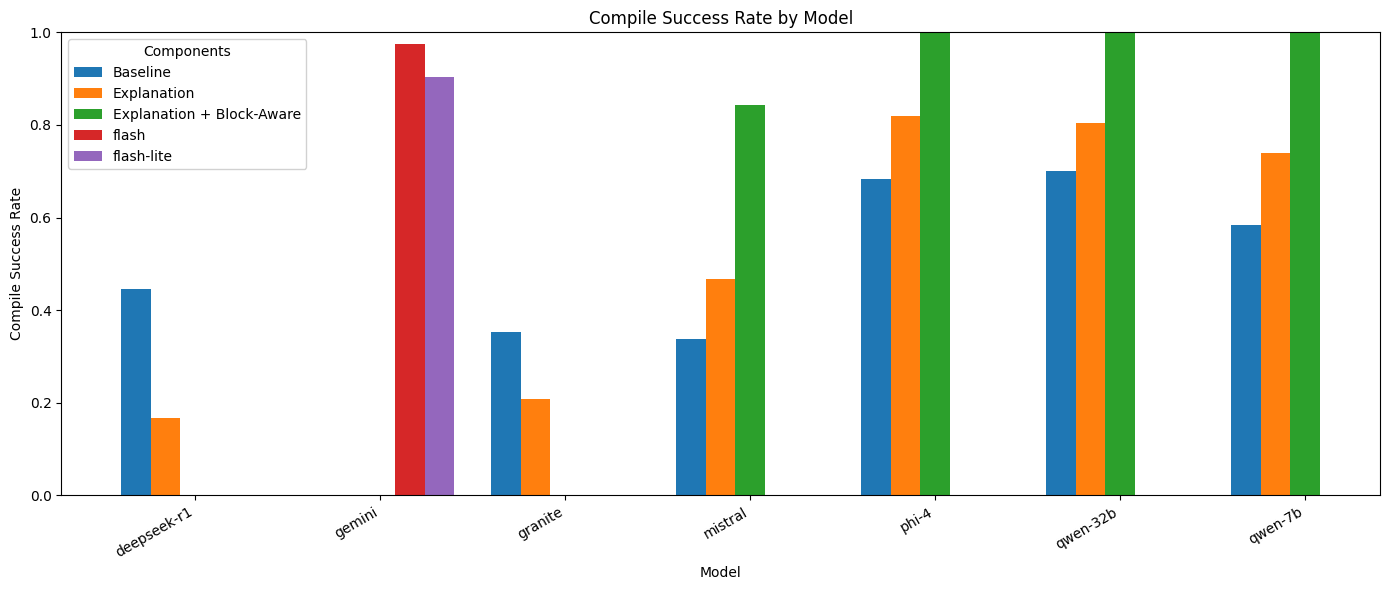

In [63]:
plot_compile_success_by_model_config(rates_df)


In [4]:
def normalize_token_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Inputs (prefer custom, else Google fields minus candidates if total not available)
    df["input_tokens"] = np.where(
        df.get("total_input_tokens").notna() if "total_input_tokens" in df else False,
        df.get("total_input_tokens"),
        df.get("prompt_token_count"),
    )
    df["output_tokens"] = np.where(
        df.get("total_output_tokens").notna() if "total_output_tokens" in df else False,
        df.get("total_output_tokens"),
        df.get("candidates_token_count"),
    )

    # Total: prefer explicit total, else sum of input+output, else provided total_token_count
    df["total_tokens"] = np.select(
        [
            df.get("total_tokens").notna() if "total_tokens" in df else False,
            (df.get("input_tokens").notna() & df.get("output_tokens").notna()),
        ],
        [
            df.get("total_tokens"),
            df.get("input_tokens").fillna(0) + df.get("output_tokens").fillna(0),
        ],
        default=df.get("total_token_count"),
    )
    return df

In [5]:
def print_summary(df_all: pd.DataFrame, df_latest: pd.DataFrame) -> None:
    print("------ Summary ------")
    print(f"All rows: {len(df_all)}")
    print(f"Unique files: {df_all['file_hash'].nunique() if not df_all.empty else 0}")
    print(f"Kept (latest per file): {len(df_latest)}\n")

    if df_latest.empty:
        return

    pass_rate = float(df_latest["compiled_success"].mean()) if "compiled_success" in df_latest else float("nan")
    avg_retries = float(df_latest["total_attempts_completed"].mean()) if "total_attempts_completed" in df_latest else float("nan")
    avg_latency = float(df_latest["llm_latency_ms_total"].mean()) if "llm_latency_ms_total" in df_latest else float("nan")
    avg_line_diff = float(df_latest["diff_lines"].mean()) if "diff_lines" in df_latest else float("nan")
    print(f"Pass rate: {pass_rate:.3f}")
    print(f"Avg retries: {avg_retries:.2f}")
    print(f"Avg LLM latency (ms): {avg_latency:.0f}")
    print(f"Avg Line Diff: {avg_line_diff:.2f}")

    if "bytecode_version" in df_latest:
        bb = df_latest.groupby("bytecode_version")["compiled_success"].mean().rename("pass_rate")
        print("\nPass rate by bytecode_version:\n", bb.to_string())


In [6]:
def make_plots(df_latest: pd.DataFrame) -> None:
    """Quick matplotlib plots. Close each figure after show if embedding elsewhere."""
    if df_latest.empty:
        print("No data to plot.")
        return

    # ---------- helper: generic boxplot by outcome ----------
    def _boxplot_by_outcome(df: pd.DataFrame, column: str, title: Optional[str] = None, log: bool = False) -> None:
        if "compiled_success" not in df or column not in df:
            return
        s_ok = pd.to_numeric(df.loc[df["compiled_success"] == True, column], errors="coerce").dropna()
        s_bad = pd.to_numeric(df.loc[df["compiled_success"] == False, column], errors="coerce").dropna()
        if s_ok.empty and s_bad.empty:
            return
        plt.figure()
        plt.boxplot([s_ok, s_bad], labels=["success", "failure"], showfliers=False)
        if log:
            plt.yscale("log")
        plt.title(title or f"{column} by compilation outcome")
        plt.ylabel(column)
        plt.tight_layout()
        plt.show()

    # Success vs failure counts
    if "compiled_success" in df_latest:
        counts = df_latest["compiled_success"].value_counts().rename(index={True: "success", False: "failure"})
        plt.figure()
        counts.plot(kind="bar")
        plt.title("Compilation Outcome Counts")
        plt.ylabel("Count")
        plt.xlabel("Outcome")
        plt.tight_layout()
        plt.show()

    # 1) Bar: success rate by bytecode version
    if "bytecode_version" in df_latest and "compiled_success" in df_latest:
        by_ver = df_latest.groupby("bytecode_version")["compiled_success"].mean().sort_values()
        plt.figure()
        by_ver.plot(kind="bar")
        plt.title("Pass rate by bytecode_version")
        plt.ylabel("Pass rate")
        plt.xlabel("bytecode_version")
        plt.tight_layout()
        plt.show()

    # 2) Histogram: LLM latency
    if "llm_latency_ms_total" in df_latest:
        plt.figure()
        pd.to_numeric(df_latest["llm_latency_ms_total"], errors="coerce").dropna().plot(kind="hist", bins=30)
        plt.title("LLM latency (ms)")
        plt.xlabel("ms")
        plt.tight_layout()
        plt.show()

    # 3) Boxplots split by outcome (added)
    _boxplot_by_outcome(df_latest, "total_attempts_completed", "Attempts by outcome")
    _boxplot_by_outcome(df_latest, "llm_latency_ms_total", "LLM Latency (ms) by outcome", log=False)
    # If you normalized tokens earlier (recommended), this will exist:
    if "total_tokens" in df_latest:
        _boxplot_by_outcome(df_latest, "total_tokens", "Total Tokens by outcome", log=False)
    # Diff size often skewed; a log scale can help
    if "diff_lines" in df_latest:
        _boxplot_by_outcome(df_latest, "diff_lines", "Diff Lines by outcome", log=True)
    if "compile_latency_ms" in df_latest:
        _boxplot_by_outcome(df_latest, "compile_latency_ms", "Compile Latency (ms) by outcome", log=False)

    # 4) Scatter: total_tokens vs latency
    if "total_tokens" in df_latest and "llm_latency_ms_total" in df_latest:
        plt.figure()
        sub = df_latest.dropna(subset=["total_tokens", "llm_latency_ms_total"]).copy()
        sub["total_tokens"] = pd.to_numeric(sub["total_tokens"], errors="coerce")
        sub["llm_latency_ms_total"] = pd.to_numeric(sub["llm_latency_ms_total"], errors="coerce")
        sub = sub.dropna(subset=["total_tokens", "llm_latency_ms_total"])
        plt.scatter(sub["total_tokens"], sub["llm_latency_ms_total"], alpha=0.6)
        plt.title("Latency vs Total Tokens")
        plt.xlabel("total_tokens")
        plt.ylabel("llm_latency_ms_total (ms)")
        plt.tight_layout()
        plt.show()

    # 5) Top failure types
    if "compiled_success" in df_latest and "compile_error_type_after" in df_latest:
        fails = df_latest.loc[df_latest["compiled_success"] == False, "compile_error_type_after"].fillna("Unknown")
        if not fails.empty:
            top = fails.value_counts().head(10)
            plt.figure()
            top.plot(kind="bar")
            plt.title("Top failure types (latest per file)")
            plt.ylabel("count")
            plt.tight_layout()
            plt.show()
